In [ ]:
import pandas as pd
import numpy as np
import re
import keras
from tqdm import tqdm
import pickle as pkl
import gc
from sklearn.metrics import accuracy_score
from gensim.models import Word2Vec
from scipy.spatial.distance import euclidean
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sklearn.decomposition import PCA
import multiprocessing
import os
gc.enable()

import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import StratifiedKFold

import statsmodels.api as sm
import pylab as plt
from scipy import stats

%pylab inline

from google.colab import drive
drive.mount('/content/drive')

In [ ]:
it = 10
os.makedirs('/content/drive/My Drive/Colab Notebooks/Diplom/models/word_to_vec/{0}'.format(it))

# Word2Vec для последовательностей товаров

###Считываем данные и подготавливаем выборку для обучения word2vec

In [ ]:
order_features = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Diplom/instacart-market-basket-analysis/test_train/order_features.csv')
order_features['prod_seq'] = order_features['prod_seq'].apply(lambda x: list(np.fromstring(x.strip('[ ]'), dtype=int, sep=', ')))
order_features['prev_seq'] = order_features['prev_seq'].apply(lambda x: list(np.fromstring(x.strip('[ ]'), dtype=int, sep=', ')))
order_features['prev_orders_seq'] = order_features['prev_orders_seq'].apply(lambda x: list(np.fromstring(x.strip('[ ]'), dtype=int, sep=', ')))

train_positive = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Diplom/instacart-market-basket-analysis/test_train/train_positive.csv')
train_negative = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Diplom/instacart-market-basket-analysis/test_train/train_negative.csv')

with open('/content/drive/My Drive/Colab Notebooks/Diplom/instacart-market-basket-analysis/test_train/id_to_token.pkl', 'rb') as f:
  id_to_token = pkl.load(f)

with open('/content/drive/My Drive/Colab Notebooks/Diplom/instacart-market-basket-analysis/test_train/token_to_id.pkl', 'rb') as f:
  token_to_id = pkl.load(f)

with open('/content/drive/My Drive/Colab Notebooks/Diplom/instacart-market-basket-analysis/test_train/val_orders.pkl', 'rb') as f:
  val_orders = pkl.load(f)

with open('/content/drive/My Drive/Colab Notebooks/Diplom/instacart-market-basket-analysis/test_train/test_orders.pkl', 'rb') as f:
  test_orders = pkl.load(f)

with open('/content/drive/My Drive/Colab Notebooks/Diplom/models/laser/laser_embeddings.pkl', 'rb') as f:
  laser_embeddings = pkl.load(f)

In [ ]:
df_train = order_features[(~order_features['order_id'].isin(val_orders)) & (~order_features['order_id'].isin(test_orders))].reset_index(drop=True)
df_val = order_features[order_features['order_id'].isin(val_orders)].reset_index(drop=True)
df_test = order_features[order_features['order_id'].isin(test_orders)].reset_index(drop=True)

In [ ]:
df_train['prod_seq'] = df_train['prod_seq'].apply(lambda x: list(map(lambda y: str(y), x)))

###Обучаем word2vec

In [ ]:
print(len(token_to_id)**0.25)

12.551386264918223


In [ ]:
mean = np.mean(list(map(len, df_train['prod_seq'])))
median = np.median(list(map(len, df_train['prod_seq'])))
maxlen = max(list(map(len, df_train['prod_seq'])))

print(mean)
print(median)
print(maxlen)

9.551242266330972
8.0
78


In [ ]:
wv_size = 100

w2v = Word2Vec(df_train['prod_seq'], size=wv_size, window=maxlen, min_count=1,  workers=multiprocessing.cpu_count())

In [ ]:
w2v.train(df_train['prod_seq'], total_examples=df_train.shape[0], epochs=50)

(46400060, 48937700)

In [ ]:
w2v.save('/content/drive/My Drive/Colab Notebooks/Diplom/models/word_to_vec/{0}/w2v_size100_eps500.model'.format(it))

# Word2Vec + XGB

###Понижаем размерность векторов word2vec

In [ ]:
pos_neg = pd.concat((train_positive, train_negative), axis=0)

In [ ]:
data_train = pos_neg[(~pos_neg['order_id'].isin(val_orders)) & (~pos_neg['order_id'].isin(test_orders))].sample(frac=1).drop_duplicates(subset=['uxp_total_bought', 'uxp_reorder_ratio',
       'times_lastN', 'u_total_orders', 'u_reordered_ratio', 'p_total_purchases', 'p_reorder_ratio', 'order_dow',
        'order_hour_of_day', 'days_since_prior_order'])
data_val = pos_neg[pos_neg['order_id'].isin(val_orders)].sample(frac=1)
data_test = pos_neg[pos_neg['order_id'].isin(test_orders)].sample(frac=1)

In [ ]:
w2v_matrix = np.zeros((len(id_to_token), 100))
for i_d, token in id_to_token.items():
  w2v_matrix[i_d, :] = w2v.wv[str(token)]

In [ ]:
pca = PCA(n_components=13, random_state=432)

w2v_matrix_red = pca.fit_transform(w2v_matrix)

In [ ]:
w2v_to_df = np.zeros((w2v_matrix_red.shape[0], w2v_matrix_red.shape[1] + 1))
for i_d, token in id_to_token.items():
  w2v_to_df[i_d, 0] = token
  w2v_to_df[i_d, 1:] = w2v_matrix_red[i_d, :]

In [ ]:
w2v_df = pd.DataFrame(w2v_to_df, columns=['product_id', '0', '1', '2', '3', '4', '5', '6', '7' ,'8', '9', '10', '11', '12'])

###Собираем новый датасет для бустинга

In [ ]:
new_data_train = data_train.merge(w2v_df, how='inner', on='product_id')
new_data_val = data_val.merge(w2v_df, how='inner', on='product_id')
new_data_test = data_test.merge(w2v_df, how='inner', on='product_id')

prods_df = train_positive.merge(w2v_df, how='inner', on='product_id')

In [ ]:
new_data_train = new_data_train.sample(frac=1).reset_index(drop=True)

In [ ]:
new_val_set = new_data_val[new_data_val['label'] == 1]
new_test_set = new_data_test[new_data_test['label'] == 1]

In [ ]:
best_params = {'colsample_bytree': 0.4,
 'eval_metric': 'logloss',
 'gamma': 0,
 'max_depth': 3,
 'min_child_weight': 1,
 'subsample': 0.6}

###Ищем оптимальные параметры для бустинга на валидации

In [ ]:
feat_cols = ['uxp_total_bought', 'uxp_reorder_ratio', 'times_lastN', 'u_total_orders', 'u_reordered_ratio', 'p_total_purchases',
             'p_reorder_ratio', 'order_dow', 'order_hour_of_day', 'days_since_prior_order', 'label']

In [ ]:
params = [{'eval_metric':'logloss', 'min_child_weight':i, 'gamma':j, 'subsample':k, 'colsample_bytree':x, 'max_depth':y} for i in [1, 5] 
       for j in [0, 1] for k in [0.6, 0.75, 0.8] for x in [0.4, 0.6] for y in [3, 5]]

 42%|████▏     | 20/48 [1:58:42<2:47:45, 359.47s/it]/usr/local/lib/python3.6/dist-packages/xgboost/plotting.py:84: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  _, ax = plt.subplots(1, 1)
100%|██████████| 48/48 [4:45:48<00:00, 357.26s/it]


{'eval_metric': 'logloss', 'min_child_weight': 1, 'gamma': 0, 'subsample': 0.6, 'colsample_bytree': 0.4, 'max_depth': 3}


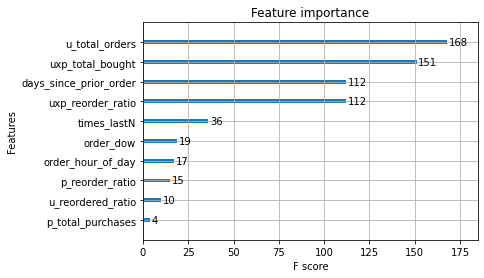

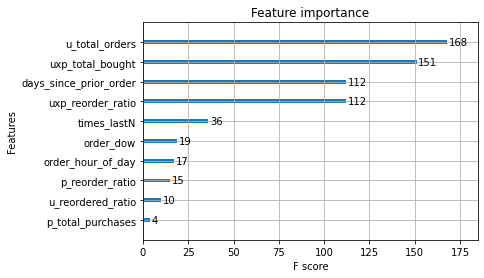

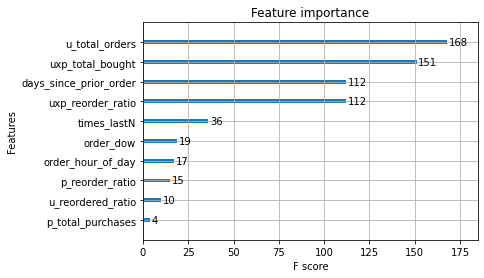

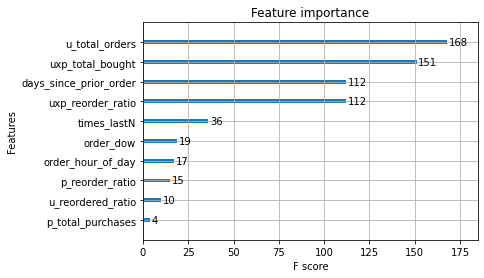

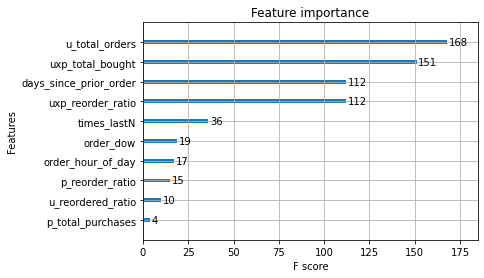

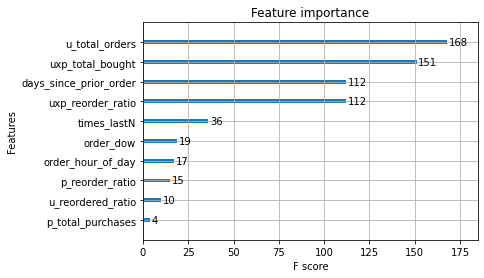

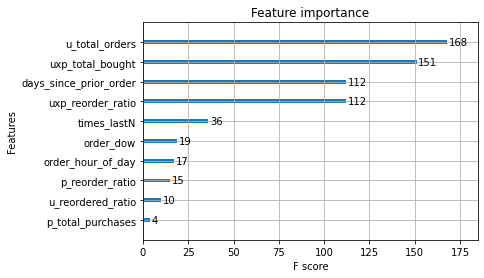

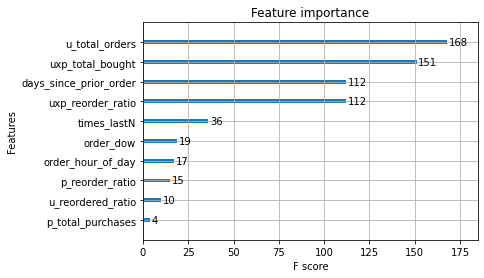

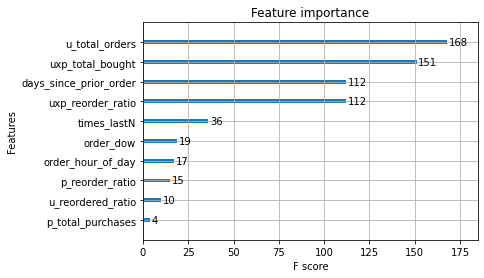

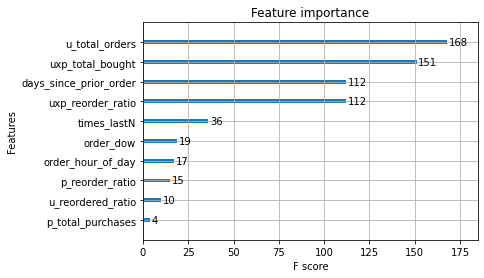

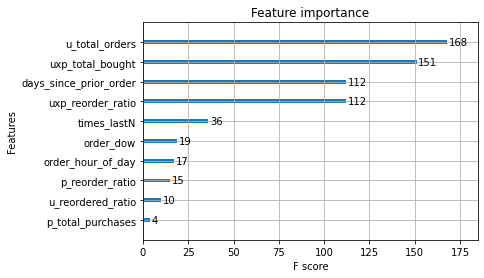

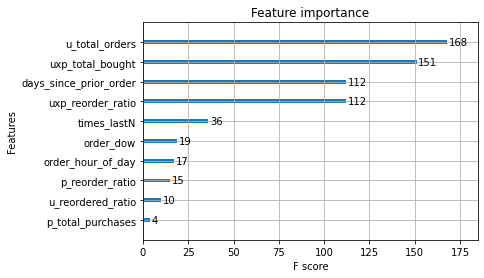

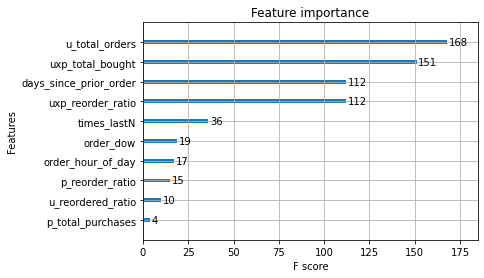

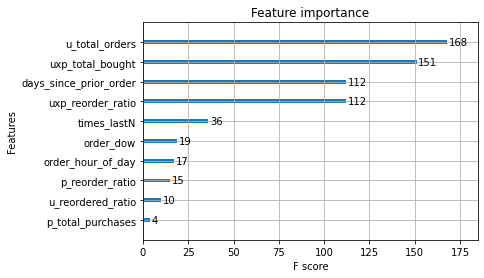

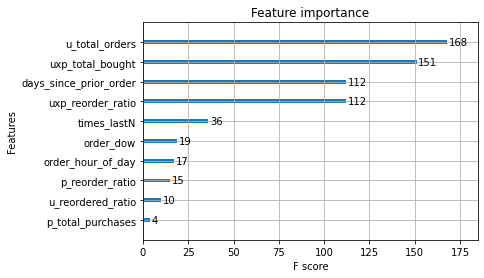

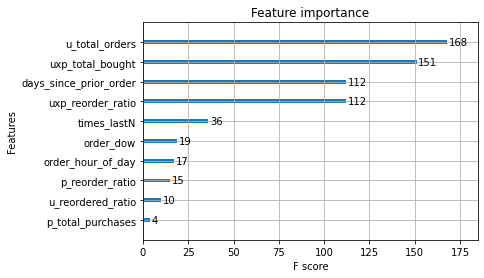

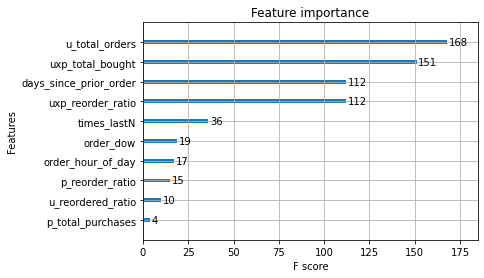

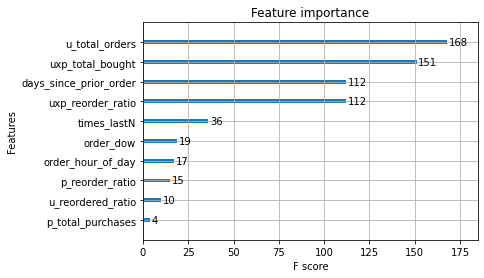

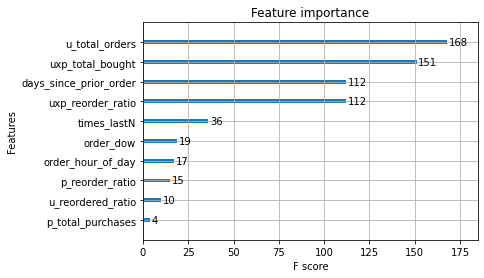

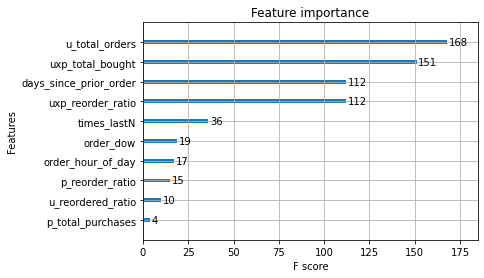

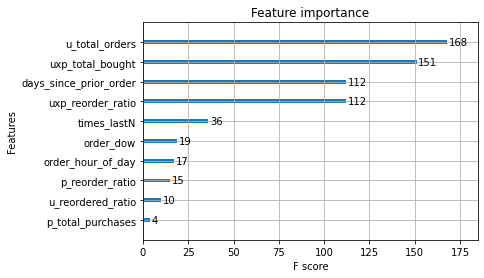

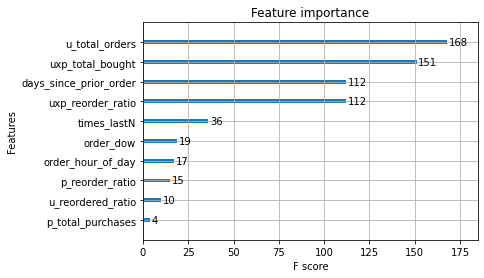

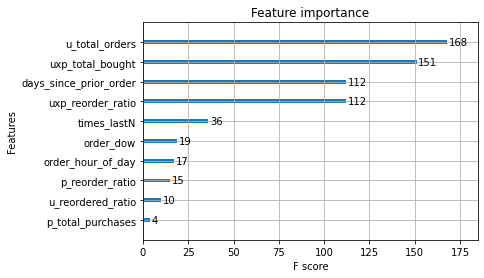

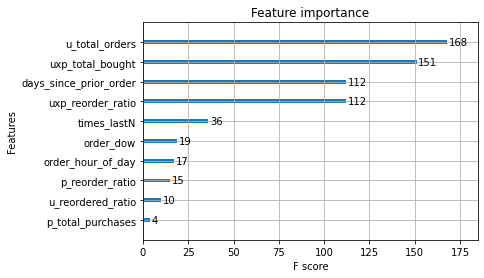

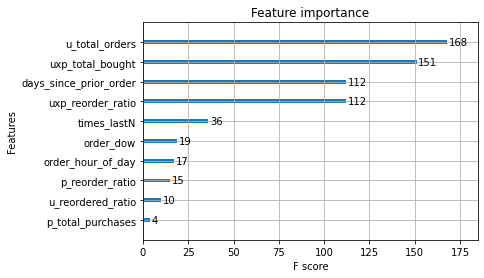

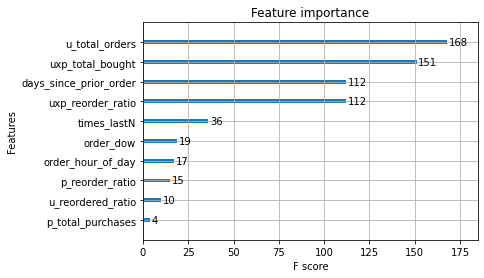

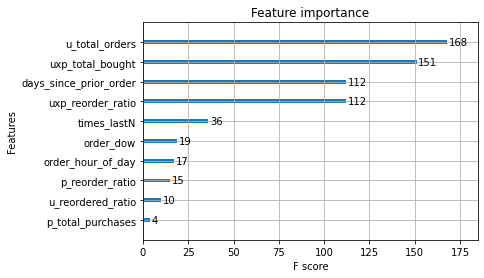

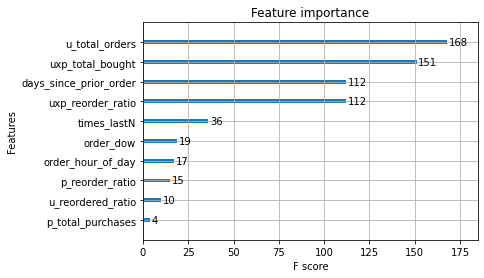

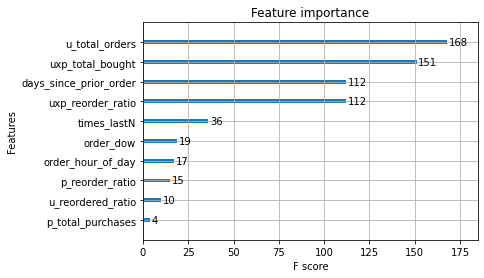

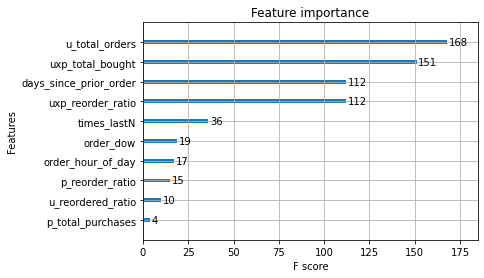

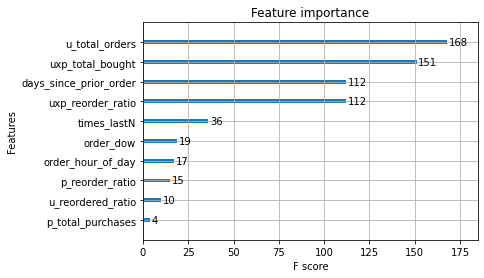

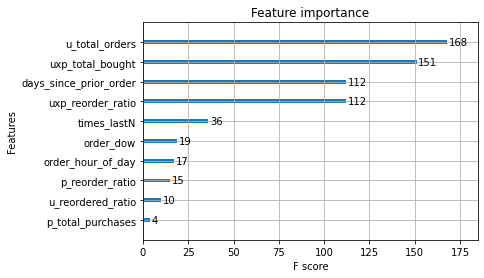

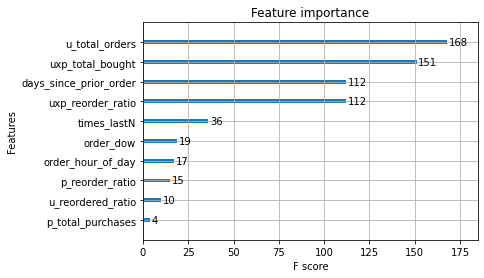

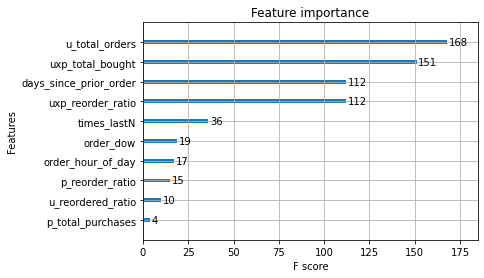

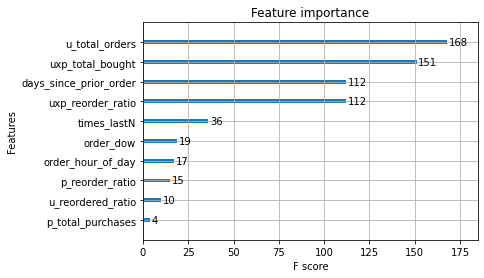

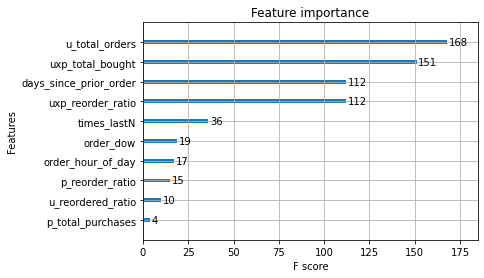

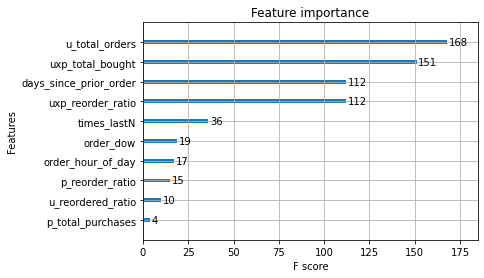

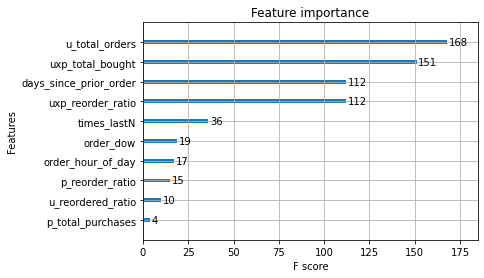

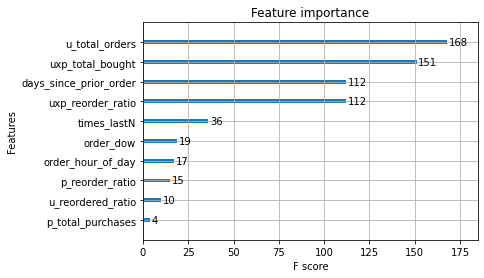

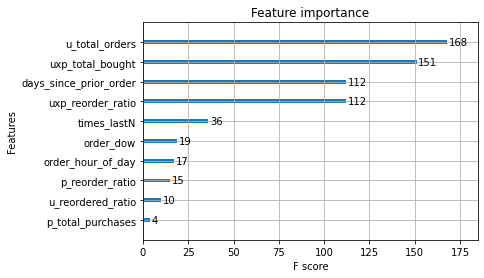

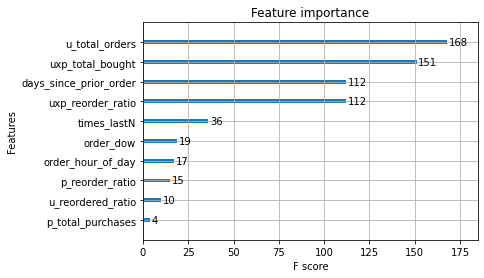

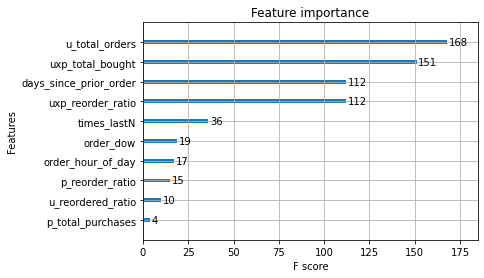

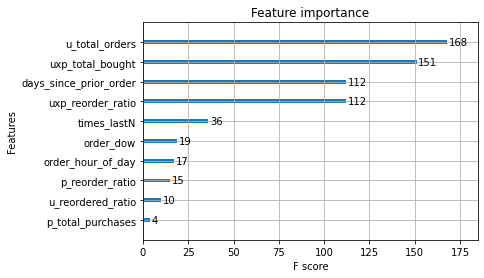

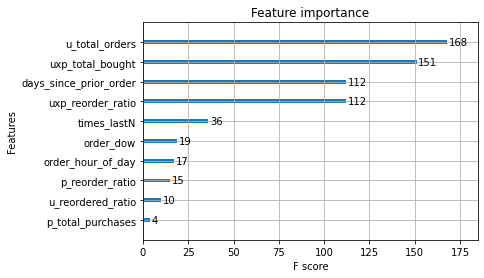

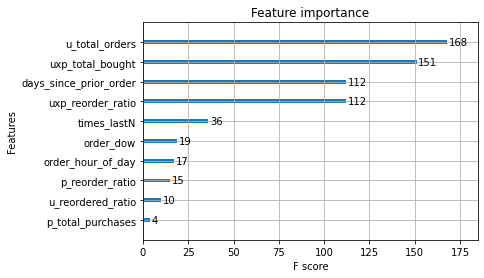

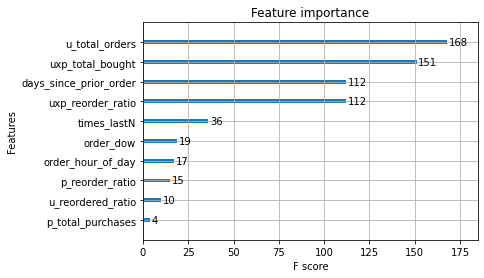

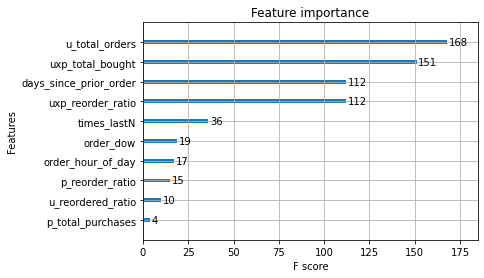

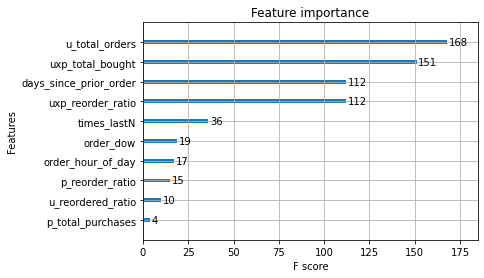

In [ ]:
best_params = params[0]
best_quality = 0

for param in tqdm(params, position=0):
  X_train, y_train = new_data_train[feat_cols[:-1]], new_data_train[feat_cols[-1]]

  xgbc = xgb.XGBClassifier(objective='binary:logistic', parameters=param, num_boost_round=10, n_jobs=-1, silent=False)

  model_xgb = xgbc.fit(X_train, y_train)

  xgb.plot_importance(model_xgb)

  precision_xgb = {}
  recall_xgb = {}
  for i in range(1, 11):
    precision_xgb[i] = 0
    recall_xgb[i] = 0

  total = 0

  for user_id, group_u in new_val_set.groupby('user_id'):

    for order_id, group_o in group_u.groupby('order_id'):
      #Купленные товары
      bought = np.array(list(set(group_o['product_id'])))

      #Ищем товары, которые порекомендует бустинг
      order = group_o[['order_id', 'order_dow', 'order_hour_of_day', 'days_since_prior_order']]
      prods = prods_df[prods_df['user_id']==user_id].drop_duplicates(subset=['product_id'])

      prods['order_dow'] = prods['order_dow'].apply(lambda x: order['order_dow'].values[0])
      prods['order_hour_of_day'] = prods['order_hour_of_day'].apply(lambda x: order['order_hour_of_day'].values[0])
      prods['days_since_prior_order'] = prods['days_since_prior_order'].apply(lambda x: order['days_since_prior_order'].values[0])

      prods['prob'] =  model_xgb.predict_proba(prods[feat_cols[:-1]])[:, 1]

      for i in range(1, 11):
        recommended_xgb = np.array(list(map(lambda x:int(x[0]),sorted(prods[['product_id', 'prob']].values, key=lambda x: x[1], reverse=True)[:i])))
        precision_xgb[i] += np.intersect1d(bought, recommended_xgb).shape[0]/recommended_xgb.shape[0]
        recall_xgb[i] += np.intersect1d(bought, recommended_xgb).shape[0]/bought.shape[0]

      total += 1

  for i in range(1, 11):
    precision_xgb[i] = precision_xgb[i]/total
    recall_xgb[i] = recall_xgb[i]/total

  quality_precision = []
  quality_recall = []

  for i in range(1, 11):
    quality_precision.append(precision_xgb[i])
    quality_recall.append(recall_xgb[i])
  new_quality = (np.mean(quality_precision) + np.mean(quality_recall))/2.

  if new_quality > best_quality:
    best_quality = new_quality
    best_params = param

print(best_params)

###Обучаем и проверяем качество на валидации

С признаками w2v

100%|██████████| 6605/6605 [05:04<00:00, 21.67it/s]




{1: 0.48523845571536717, 2: 0.44000757002271007, 3: 0.4051476154428444, 4: 0.376810497098158, 5: 0.3543918748422754, 6: 0.33570653545293744, 7: 0.3206475974189951, 8: 0.3072756930175552, 9: 0.29627497807097836, 10: 0.28602600843515896}
{1: 0.08801493583697664, 2: 0.1466071969771405, 3: 0.19508364681607313, 4: 0.23332155894226245, 5: 0.2678504638633832, 6: 0.2982015252276272, 7: 0.3255127214926126, 8: 0.3511032351277985, 9: 0.37480850014842754, 10: 0.39584588541270743}


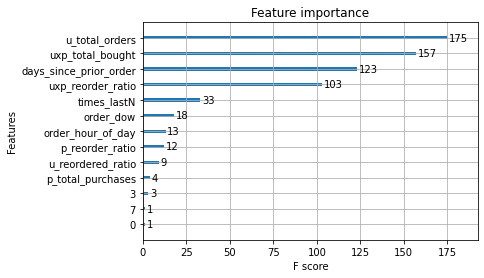

In [ ]:
feat_cols = ['uxp_total_bought', 'uxp_reorder_ratio', 'times_lastN', 'u_total_orders', 'u_reordered_ratio', 'p_total_purchases',
             'p_reorder_ratio', 'order_dow', 'order_hour_of_day', 'days_since_prior_order',
             '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', 'label']

X_train, y_train = new_data_train[feat_cols[:-1]], new_data_train[feat_cols[-1]]

parameters = best_params

xgbc = xgb.XGBClassifier(objective='binary:logistic', parameters=parameters, num_boost_round=10, n_jobs=-1, silent=False)

model_xgb = xgbc.fit(X_train, y_train)

xgb.plot_importance(model_xgb)


precision_xgb = {}
recall_xgb = {}
for i in range(1, 11):
  precision_xgb[i] = 0
  recall_xgb[i] = 0

total = 0

for user_id, group_u in tqdm(new_val_set.groupby('user_id'), position=0):

  for order_id, group_o in group_u.groupby('order_id'):
    #Купленные товары
    bought = np.array(list(set(group_o['product_id'])))

    #Ищем товары, которые порекомендует бустинг
    order = group_o[['order_id', 'order_dow', 'order_hour_of_day', 'days_since_prior_order']]
    prods = prods_df[prods_df['user_id']==user_id].drop_duplicates(subset=['product_id'])

    prods['order_dow'] = prods['order_dow'].apply(lambda x: order['order_dow'].values[0])
    prods['order_hour_of_day'] = prods['order_hour_of_day'].apply(lambda x: order['order_hour_of_day'].values[0])
    prods['days_since_prior_order'] = prods['days_since_prior_order'].apply(lambda x: order['days_since_prior_order'].values[0])

    prods['prob'] =  model_xgb.predict_proba(prods[feat_cols[:-1]])[:, 1]

    for i in range(1, 11):
      recommended_xgb = np.array(list(map(lambda x:int(x[0]),sorted(prods[['product_id', 'prob']].values, key=lambda x: x[1], reverse=True)[:i])))
      precision_xgb[i] += np.intersect1d(bought, recommended_xgb).shape[0]/recommended_xgb.shape[0]
      recall_xgb[i] += np.intersect1d(bought, recommended_xgb).shape[0]/bought.shape[0]

    total += 1

for i in range(1, 11):
  precision_xgb[i] = precision_xgb[i]/total
  recall_xgb[i] = recall_xgb[i]/total

print('\n')
print(precision_xgb)
print(recall_xgb)

Без признаков w2v

100%|██████████| 6605/6605 [05:17<00:00, 20.79it/s]




{1: 0.4573807721423164, 2: 0.40995457986373957, 3: 0.37170073176886054, 4: 0.3430418874589961, 5: 0.31929094120614737, 6: 0.3000580368407741, 7: 0.2849360152842478, 8: 0.27120183122454145, 9: 0.2600045059659072, 10: 0.24982282542084663}
{1: 0.08397486206264411, 2: 0.13725830578257878, 3: 0.17592330991120936, 4: 0.20600201336730378, 5: 0.2291895409241214, 6: 0.24866415872891562, 7: 0.2656058075154829, 8: 0.27989976210744105, 9: 0.2934420846822027, 10: 0.3051873753307771}


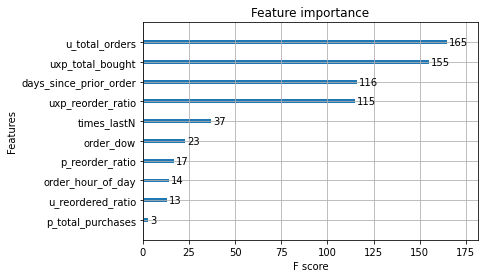

In [ ]:
feat_cols = ['uxp_total_bought', 'uxp_reorder_ratio', 'times_lastN', 'u_total_orders', 'u_reordered_ratio', 'p_total_purchases',
             'p_reorder_ratio', 'order_dow', 'order_hour_of_day', 'days_since_prior_order', 'label']

X_train, y_train = new_data_train[feat_cols[:-1]], new_data_train[feat_cols[-1]]

parameters = best_params

xgbc = xgb.XGBClassifier(objective='binary:logistic', parameters=parameters, num_boost_round=10, n_jobs=-1, silent=False)

model_xgb = xgbc.fit(X_train, y_train)

xgb.plot_importance(model_xgb)

precision_xgb = {}
recall_xgb = {}
for i in range(1, 11):
  precision_xgb[i] = 0
  recall_xgb[i] = 0

total = 0

for user_id, group_u in tqdm(new_val_set.groupby('user_id'), position=0):

  for order_id, group_o in group_u.groupby('order_id'):
    #Купленные товары
    bought = np.array(list(set(group_o['product_id'])))

    #Ищем товары, которые порекомендует бустинг
    order = group_o[['order_id', 'order_dow', 'order_hour_of_day', 'days_since_prior_order']]
    prods = prods_df[prods_df['user_id']==user_id].drop_duplicates(subset=['product_id'])

    prods['order_dow'] = prods['order_dow'].apply(lambda x: order['order_dow'].values[0])
    prods['order_hour_of_day'] = prods['order_hour_of_day'].apply(lambda x: order['order_hour_of_day'].values[0])
    prods['days_since_prior_order'] = prods['days_since_prior_order'].apply(lambda x: order['days_since_prior_order'].values[0])

    prods['prob'] =  model_xgb.predict_proba(prods[feat_cols[:-1]])[:, 1]

    for i in range(1, 11):
      recommended_xgb = np.array(list(map(lambda x:int(x[0]),sorted(prods[['product_id', 'prob']].values, key=lambda x: x[1], reverse=True)[:i])))
      precision_xgb[i] += np.intersect1d(bought, recommended_xgb).shape[0]/recommended_xgb.shape[0]
      recall_xgb[i] += np.intersect1d(bought, recommended_xgb).shape[0]/bought.shape[0]

    total += 1

for i in range(1, 11):
  precision_xgb[i] = precision_xgb[i]/total
  recall_xgb[i] = recall_xgb[i]/total

print('\n')
print(precision_xgb)
print(recall_xgb)

###Проверяем качество на тесте

С признаками w2v

100%|██████████| 6605/6605 [04:07<00:00, 26.66it/s]




{1: 0.46333489023820645, 2: 0.42213918729565625, 3: 0.3930562042659255, 4: 0.3682702786859724, 5: 0.3481908765374358, 6: 0.33090300482640067, 7: 0.3178116589933585, 8: 0.30653188318765134, 9: 0.2958956280628442, 10: 0.28632481483952055}
{1: 0.0812302003315941, 2: 0.1371491068500306, 3: 0.18500946787980352, 4: 0.2255301768792638, 5: 0.2596876941306564, 6: 0.28968485532191374, 7: 0.317850510825213, 8: 0.3440541161650483, 9: 0.36770085309572415, 10: 0.38920785554653897}


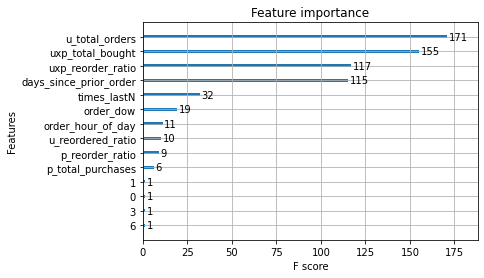

In [ ]:
feat_cols = ['uxp_total_bought', 'uxp_reorder_ratio', 'times_lastN', 'u_total_orders', 'u_reordered_ratio', 'p_total_purchases',
             'p_reorder_ratio', 'order_dow', 'order_hour_of_day', 'days_since_prior_order',
             '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', 'label']

X_train, y_train = new_data_train[feat_cols[:-1]], new_data_train[feat_cols[-1]]

parameters = best_params

xgbc = xgb.XGBClassifier(objective='binary:logistic', parameters=parameters, num_boost_round=10, n_jobs=-1, silent=False)

model_xgb = xgbc.fit(X_train, y_train)

xgb.plot_importance(model_xgb)

precision_xgb = {}
recall_xgb = {}
for i in range(1, 11):
  precision_xgb[i] = 0
  recall_xgb[i] = 0

total = 0

for user_id, group_u in tqdm(new_test_set.groupby('user_id'), position=0):

  for order_id, group_o in group_u.groupby('order_id'):
    #Купленные товары
    bought = np.array(list(set(group_o['product_id'])))

    #Ищем товары, которые порекомендует бустинг
    order = group_o[['order_id', 'order_dow', 'order_hour_of_day', 'days_since_prior_order']]
    prods = prods_df[prods_df['user_id']==user_id].drop_duplicates(subset=['product_id'])

    prods['order_dow'] = prods['order_dow'].apply(lambda x: order['order_dow'].values[0])
    prods['order_hour_of_day'] = prods['order_hour_of_day'].apply(lambda x: order['order_hour_of_day'].values[0])
    prods['days_since_prior_order'] = prods['days_since_prior_order'].apply(lambda x: order['days_since_prior_order'].values[0])

    prods['prob'] =  model_xgb.predict_proba(prods[feat_cols[:-1]])[:, 1]

    for i in range(1, 11):
      recommended_xgb = np.array(list(map(lambda x:int(x[0]),sorted(prods[['product_id', 'prob']].values, key=lambda x: x[1], reverse=True)[:i])))
      precision_xgb[i] += np.intersect1d(bought, recommended_xgb).shape[0]/recommended_xgb.shape[0]
      recall_xgb[i] += np.intersect1d(bought, recommended_xgb).shape[0]/bought.shape[0]

    total += 1

for i in range(1, 11):
  precision_xgb[i] = precision_xgb[i]/total
  recall_xgb[i] = recall_xgb[i]/total

print('\n')
print(precision_xgb)
print(recall_xgb)

metric_with_w2v_feats = {}

metric_with_w2v_feats[it] = [precision_xgb, recall_xgb]

with open('/content/drive/My Drive/Colab Notebooks/Diplom/models/word_to_vec/{0}/metric_with_w2v_feats.pkl'.format(it), 'wb', ) as f:
  pkl.dump(metric_with_w2v_feats, f)

Без признаков w2v

In [ ]:
feat_cols = ['uxp_total_bought', 'uxp_reorder_ratio', 'times_lastN', 'u_total_orders', 'u_reordered_ratio', 'p_total_purchases',
             'p_reorder_ratio', 'order_dow', 'order_hour_of_day', 'days_since_prior_order', 'label']

X_train, y_train = new_data_train[feat_cols[:-1]], new_data_train[feat_cols[-1]]

parameters = best_params

xgbc = xgb.XGBClassifier(objective='binary:logistic', parameters=parameters, num_boost_round=10, n_jobs=-1, silent=False)

model_xgb = xgbc.fit(X_train, y_train)

xgb.plot_importance(model_xgb)

precision_xgb = {}
recall_xgb = {}
for i in range(1, 11):
  precision_xgb[i] = 0
  recall_xgb[i] = 0

total = 0

for user_id, group_u in tqdm(new_test_set.groupby('user_id'), position=0):

  for order_id, group_o in group_u.groupby('order_id'):
    #Купленные товары
    bought = np.array(list(set(group_o['product_id'])))

    #Ищем товары, которые порекомендует бустинг
    order = group_o[['order_id', 'order_dow', 'order_hour_of_day', 'days_since_prior_order']]
    prods = prods_df[prods_df['user_id']==user_id].drop_duplicates(subset=['product_id'])

    prods['order_dow'] = prods['order_dow'].apply(lambda x: order['order_dow'].values[0])
    prods['order_hour_of_day'] = prods['order_hour_of_day'].apply(lambda x: order['order_hour_of_day'].values[0])
    prods['days_since_prior_order'] = prods['days_since_prior_order'].apply(lambda x: order['days_since_prior_order'].values[0])

    prods['prob'] =  model_xgb.predict_proba(prods[feat_cols[:-1]])[:, 1]

    for i in range(1, 11):
      recommended_xgb = np.array(list(map(lambda x:int(x[0]),sorted(prods[['product_id', 'prob']].values, key=lambda x: x[1], reverse=True)[:i])))
      precision_xgb[i] += np.intersect1d(bought, recommended_xgb).shape[0]/recommended_xgb.shape[0]
      recall_xgb[i] += np.intersect1d(bought, recommended_xgb).shape[0]/bought.shape[0]

    total += 1

for i in range(1, 11):
  precision_xgb[i] = precision_xgb[i]/total
  recall_xgb[i] = recall_xgb[i]/total

print('\n')
print(precision_xgb)
print(recall_xgb)

metric_without_w2v_feats = {}

metric_without_w2v_feats[it] = [precision_xgb, recall_xgb]

with open('/content/drive/My Drive/Colab Notebooks/Diplom/models/word_to_vec/{0}/metric_without_w2v_feats.pkl'.format(it), 'wb') as f:
  pkl.dump(metric_without_w2v_feats, f)